
# 2.2-kW induction motor, 6-step mode

This example simulates V/Hz control of a 2.2-kW induction motor drive. The
six-step overmodulation is enabled, which increases the fundamental voltage as
well as the harmonics. Since the PWM is not synchronized with the stator
frequency, the harmonic content also depends on the ratio between the stator
frequency and the sampling frequency.


In [1]:
pip install motulator

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.8/78.8 kB 2.4 MB/s eta 0:00:00


In [2]:
import numpy as np

from motulator.drive import model
import motulator.drive.control.im as control
from motulator.drive.utils import (
    BaseValues, InductionMachinePars, InductionMachineInvGammaPars,
    NominalValues, plot, plot_extra, Sequence)

Compute base values based on the nominal values (just for figures).



In [3]:
nom = NominalValues(U=400, I=5, f=50, P=2.2e3, tau=14.6)
base = BaseValues.from_nominal(nom, n_p=2)

Create the system model.



In [4]:
# Configure the induction machine using its inverse-Γ parameters
mdl_ig_par = InductionMachineInvGammaPars(
    n_p=2, R_s=3.7, R_R=2.1, L_sgm=.021, L_M=.224)
mdl_par = InductionMachinePars.from_inv_gamma_model_pars(mdl_ig_par)
machine = model.InductionMachine(mdl_par)
# Mechanics with quadratic load torque coefficient
k = .2*nom.tau/(base.w/base.n_p)**2
mechanics = model.StiffMechanicalSystem(J=.015, B_L=lambda w_M: k*np.abs(w_M))
converter = model.VoltageSourceConverter(u_dc=540)
mdl = model.Drive(converter, machine, mechanics)
mdl.pwm = model.CarrierComparison()  # Enable the PWM model

Control system (parametrized as open-loop V/Hz control).



In [5]:
par = InductionMachineInvGammaPars(R_s=0*3.7, R_R=0*2.1, L_sgm=.021, L_M=.224)
ctrl = control.VHzControl(
    control.VHzControlCfg(
        par, nom_psi_s=base.psi, k_u=0, k_w=0, overmodulation="six_step"))

Set the speed reference and the external load torque.



In [6]:
# Speed reference
times = np.array([0, .1, .3, 1])*2
values = np.array([0, 0, 1, 1])*2*base.w
ctrl.ref.w_m = Sequence(times, values)

# External load torque could be set here, now zero
mdl.mechanics.tau_L = lambda t: (t > 1.)*nom.tau*0

Create the simulation object and simulate it.



In [7]:
sim = model.Simulation(mdl, ctrl)
sim.simulate(t_stop=2)

Plot results in per-unit values.



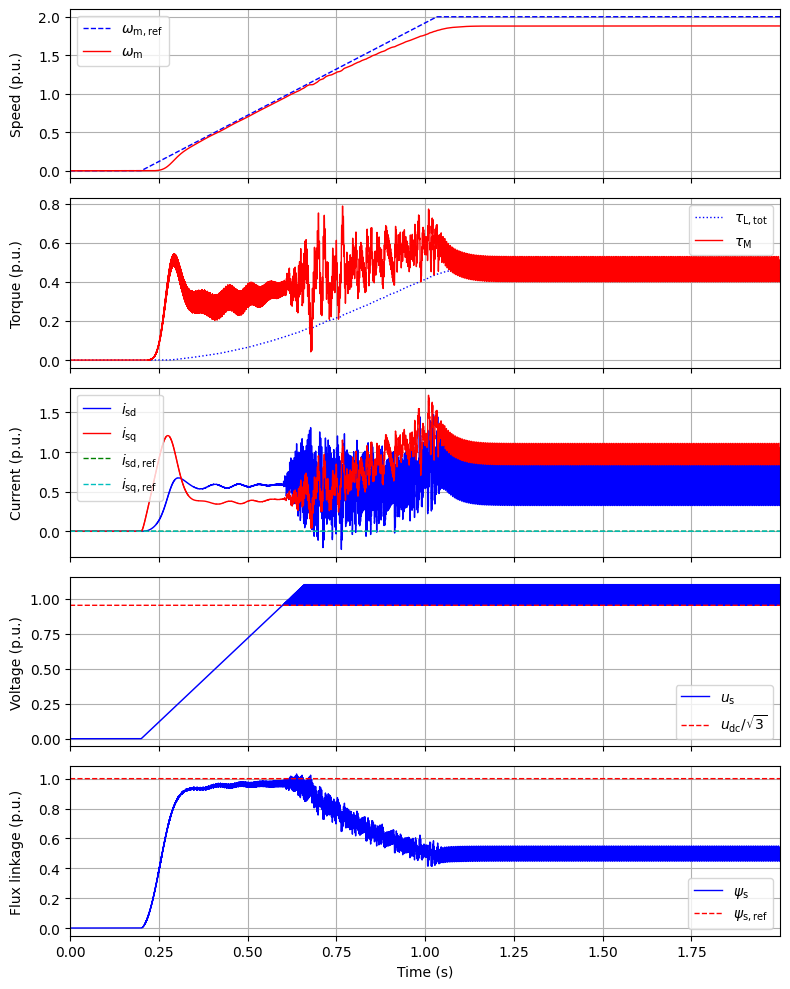

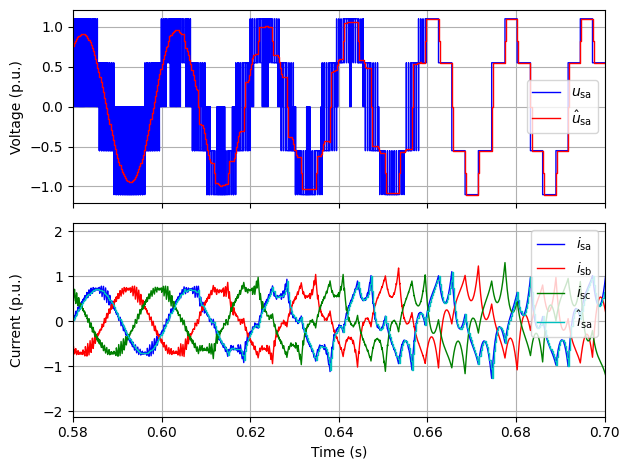

In [8]:
# sphinx_gallery_thumbnail_number = 2
plot(sim, base)
plot_extra(sim, base, t_span=(.58, .7))